# Banking Dataset - Análise exploratória

Os depósitos a prazo representam uma importante fonte de receita para os bancos. Trata-se de um investimento em dinheiro retido em uma instituição financeira, onde o montante é investido por um período fixo, a uma taxa de juros previamente acordada. Para maximizar a captação desses depósitos, os bancos implementam diversas estratégias de marketing direto, incluindo marketing por e-mail, publicidade, telemarketing e marketing digital.

Dentre essas estratégias, o telemarketing continua sendo um dos métodos mais eficazes para alcançar os clientes. No entanto, essa abordagem exige um grande investimento, pois grandes centrais de atendimento são contratadas para executar essas campanhas. Portanto, é crucial identificar previamente os clientes com maior probabilidade de conversão, de modo que possam ser especificamente alvo dessas campanhas.

Este notebook focará na análise exploratória dos dados relacionados às campanhas de marketing direto (chamadas telefônicas) de uma instituição bancária portuguesa.

Nas seções seguintes, exploraremos os dados disponíveis, realizaremos a limpeza e o pré-processamento necessários e, finalmente, analisaremos diversas características dos clientes para identificar padrões que impactam a chance de um cliente efetuar o depósito, mensurado pela nossa variável resposta _y_. 

- A fonte dos dados é [_Banking Dataset - Marketing Targets_](https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targets) do Kaggle.
- A proposta do estudo foi idealizada por meu mentor, [Wagner Silva](https://github.com/wagnerjorge).
- A abordagem foram também inspirados pelo trabalho de Tuatini Godard: [_Detailed exploratory data analysis with python_](https://www.kaggle.com/code/ekami66/detailed-exploratory-data-analysis-with-python).
- Os gráficos e estilo de apresentação foram inspirados pelo trabalho de Luiz Simões: [_Um caminho para os melhores salários-versão com ML_](https://www.kaggle.com/code/luizweb/um-caminho-para-os-melhores-sal-rios-vers-o-com-ml).

# Índice

TO_DO

1. [Introdução](#1)
    1. [Configurações e bibliotecas](#1_1)
    1. [Conversão de CSV para Parquet](#1_2)
    1. [Sumarização](#1_3)
    1. [Dicionário de dados](#1_4)
1. [Variável resposta](#2)

# <a id='1'></a> 1. Introdução

TO_DO

## <a id='1_0'></a> 1.0 Configurações e bibliotecas

In [165]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import skew
from summarytools import dfSummary
from dython import nominal
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## <a id='1_1'></a> 1.1 Conversão de CSV para Parquet

O conjunto de dados original está dividido em dois arquivos de formato CSV: `train.csv` e `test.csv`. 
Converteremos os arquivos CSV para Parquet para tirar proveito de sua eficiência no armazenamento, leitura eficiente e melhor desempenho em consultas. Vamos manter os originais na pasta `data/raw` e os convertidos na pasta `data/bronze`.

Nossa análise exploratória será feita usando apenas dados do conjunto de treino. Esse conjunto de dados conta com 45221 observações e 16 variáveis explicativas além da variável resposta.

In [166]:
# Leitura dos dados em CSV
raw_banking_train = pd.read_csv('../data/raw/train.csv', sep = ';')
raw_banking_test = pd.read_csv('../data/raw/train.csv', sep = ';')

# Convertendo para Parquet na camada bronze
raw_banking_train.to_parquet('../data/bronze/banking_train.parquet')
raw_banking_test.to_parquet('../data/bronze/banking_test.parquet')

# Lendo os dados convertidos
bronze_train = pd.read_parquet('../data/bronze/banking_train.parquet')

# Visualizando algumas informações sobre nossos dados
print(bronze_train.shape)
bronze_train.head()

(45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## <a id='1_2'></a> 1.2 Sumarização

Vamos fazer uma análise preliminar dos dados. Abordaremos os dados em mais detalhes nas seções seguintes.
Observamos que não há dados faltantes em nosso conjunto de dados.

- **age:** A idade dos clientes varia de 18 a 95 anos, com uma média de aproximadamente 41 anos e um desvio padrão de 10,6 anos. A distribuição apresenta uma assimetria à direita.
- **job:** Esta é uma variável categórica que representa o tipo de trabalho do cliente. A maioria dos clientes são "blue-collar" (21,5%), "management" (20,9%) ou "technician" (16,8%).
- **marital:** Outra variável categórica, indicando o estado civil. A maioria dos clientes é casada (60,2%), seguidos por solteiros (28,3%) e divorciados (11,5%).
- **education:** O nível de educação dos clientes, sendo a maioria com ensino secundário (51,3%) ou terciário (29,4%).
- **default:** Uma variável binária indicando se o cliente tem crédito em situação de default. A grande maioria (98,2%) não está em default.
- **balance:** O saldo médio anual dos clientes, variando de -8.02 a 102.13 euros, com uma média de 1.37 euros e um desvio padrão alto de 3.04 euros.
- **housing e loan:** Variáveis binárias indicando se o cliente tem empréstimo imobiliário ou pessoal, respectivamente. A maioria tem empréstimo imobiliário (55,6%) e não tem empréstimo pessoal (84%).
- **contact:** O tipo de comunicação usado para contatar o cliente, sendo a maioria por celular (64,8%).
- **day e month:** O dia e mês do último contato, com uma distribuição multimodal para os dias.
- **duration:** A duração do último contato, em segundos, variando de 0 a 4918 segundos, com uma média de 258 segundos (aproximadamente 4 minutos).
- **campaign:** O número de contatos realizados na campanha atual, variando de 1 a 63, com uma média de aproximadamente 3 contatos.
- **pdays:** O número de dias desde o último contato de uma campanha anterior, com muitos clientes sendo contatados pela primeira vez (-1). Essa á uma  variável mista, pois temos a combinação da informação de uma variável numérica discreta com uma variável categórica binária. Para critérios de análise, vamos dividir essa variável em duas: **pdays_num** e **pdays_cat**. Observando *pdays_cat*, observamos que a maioria dos clientes (88,3%) não tiveram contato anterior.
- **previous:** O número de contatos realizados antes da campanha atual, com a maioria dos clientes (88,3%) não tendo sido contatada anteriormente.
- **poutcome:** O resultado da campanha de marketing anterior, sendo a maioria "unknown" (81,7%), seguido por "failure" (10,8%).
- **y:** Nossa variável resposta. Indica se o cliente fez um depósito a prazo. A maioria (88,3%) não fez o depósito.

In [167]:
dfSummary(bronze_train)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,age[int64],Mean (sd) : 40.9 (10.6)min < med < max:18.0 < 39.0 < 95.0IQR (CV) : 15.0 (3.9),77 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAC+UlEQVR4nO3dPU/bUBSA4XMTEjkhuo6VFrYsHTIgdWDM0n/Aj+3ajYEdKWuGKhsCnKC4mDi2O7VLIeBru/Gx3me/5g6vDAd/mTzPBWi6zrE3AHzEybE3cIgxZiAifcfluzzPn6vcD46nsaEaYwaTyeTKWhu4rH96egqNMd+JtR0aG6qI9K21wXw+f/Z9Py6ycLPZeDc3N8HDw0NfRAi1BZocqoiI+L4fn52d/XJYOqh8MzgahimoQKhQodZf/SWndptlWa/K/UCv2kItO7UnSeKlaXoRx/G1iLj8jYoWqfOM6jy1i4isVqtgsVgM9/t9t47NQZfap37XqT0MQ6Z2/MUwBRUIFSoQKlQgVKhAqFCBUKECoUIFQoUKhAoVCBUqECpUIFSoQKhQgVChAqFCBUKFCo1/XNpVmqY9EbHGGNdD8KaVBmllqFEU9ZIk+TqdTrvdbrfwYzAivGmlaVoZ6m63O/E8b3h5eRmfn5+HRdfzppXmaWWof5yenrq+ZUWEN600CsMUVGj1GbWMksMYg1jFCPUVZYcxBrHqEeorygxjDGL1INQDSgxjDGIVY5iCCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKEC96PWgMdYqkeoFeMxlnoQasV4jKUehFoTHmOpFsMUVCBUqECoUIFQoQKhQgVChQrv/nvKGDMQkb7DsW2WZT2HdcA/DoZqjBlMJpMra21Q9MBJknhpml7EcXwtIq7vKAVE5P0zat9aG8zn82ff9wtdDlytVsFisRju9/tuif0BIvLBK1O+7xe+yhKGIVdYUBmGKajAtf6GqeCzQx0RyRzXNvYWQ0JtkLK3CKZp2oui6MtoNFp2Op2k6Pr1er01xvwQEadPHkmNoX8o1M1m4xU98Ha79UREoijy7u7uhv9zvdaf/fj4OPI8bzibzcx4PH4pslZE5P7+3lsul59ns9nP8Xi8LbJ2vV6Pbm9vv02n00+u3+YqGfpLnudvrvsNWZ5IF7PWZn0AAAAASUVORK5CYII="">",0(0.0%)
2,job[object],1. blue-collar2. management3. technician4. admin.5. services6. retired7. self-employed8. entrepreneur9. unemployed10. housemaid11. other,"9,732 (21.5%)9,458 (20.9%)7,597 (16.8%)5,171 (11.4%)4,154 (9.2%)2,264 (5.0%)1,579 (3.5%)1,487 (3.3%)1,303 (2.9%)1,240 (2.7%)1,226 (2.7%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAD+CAYAAAAtWHdlAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAAD/UlEQVR4nO3cTW7TUABG0RcUIZgkqip1MV0Ei2UR2U1V1QNATMKAEWrpT2pfI3zOBurB1Ytsva+78/k8oPBh7QdgO8RGRmxkxEZGbGTERkZsZMRGRmxkdmOMz2OMjys/x8/z+fx95WdgYfvr6+svh8Phas2HmKbpfrfbfRXc/21/OByubm9vvx+Pxx9rPMDDw8On0+l0dXd393GMIbb/2H6MMY7H44+bm5tvKz7H5xX/NhEvCGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERmY/xu87ZWs9wJp/m9Z+mqb70+l0NVa8UzZN0/0Y4+daf5+GDQKZnX+ZReVfONmcahux+rrKsmo7Vl1XWVZty7+wrrKs2ggfdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MisOngxdtmW1Qcvxi7b4Vo4GYMXMuXJ5gTbuGzwYthCMngxbGGMdvBi2LJxPuqSERsZsZERGxmxkREbGbGRERsZsZERGxmxkREbGbGRSQYvhi2MEQ5eDFtwLZyMwQsZLwhk5vwZ9TPJs2ZbV1lP8ZJZ1lXWU7zGnOsq6yme5QWBjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNzCzrKuspXmO2dZX1FC9xLZyMdRWZ95xsTjLe5OLBi4ELb3XR4MXAhUu8Z/Bi4MKb+KhLRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRG5qLBi4ELl7h48GLgwlu5Fk7G4IXMa042JxizeHHwYtjCXJ4dvBi2MKfXDF4MW5iFj7pkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbm2XWVFRVzenFdZUXFXGwQyFhXkfnbyeY0Y3ZPrqssqljCo3WVRRVL+du6yqKK2fmoS0ZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERubR4MXIhaU8OXgxcmEJroWTMXgh42QjY/BCxuCFjMELGR91yYiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyBi8kDF4IeNaOBmDFzJeEMg89TPqJ5RFPFpXWVaxlD/WVZZVLOmpdZVlFYvwgkBGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkxEbmj3WVZRVLerSusqxiKa6Fk7GuIuNkI2PwQsbghYzBCxkfdcmIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MgYvJAxeCHjWjgZgxcyTjYyBi9kDF7IGLyQ8VGXjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjYzYyIiNjMELGYMXMq6FkzF4IeMFgYzYyIiNjNjIiI2M2MiIjYzYyIiNzC/IeU7iNeCxFgAAAABJRU5ErkJggg=="">",0(0.0%)
3,marital[object],1. married2. single3. divorced,"27,214 (60.2%)12,790 (28.3%)5,207 (11.5%)","<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAABFCAYAAABdVZTTAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjguNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8fJSN1AAAACXBIWXMAAA9hAAAPYQGoP6dpAAABmUlEQVR4nO3bQWrCUBRG4ZsSpE4SguBiXEQX20VkNyK+gYqTdNBpqQ7Cebzc863gIgclwb9bliUkwkftA5RHFxH7iNjVPiSZ57Is99pH0PrD4fA1DMNU+5BMSimXruu+swXXD8MwnU6n+ziOj9rHZHC9Xj/neZ7O5/MuInLFFhExjuPjeDzeah+TyL72ATX4gCCMsQljbMIYmzDGJoyxCWNswhibMMYmjLEJY2zCGJswxiaMsQnTR/z+x6r2IVlk/qz7Usplnucpkv7HqoZSyiUinrXvoLlBqCPlBqFzyidKi99sKb8VtqC5dVXWZdIWNLWuyrxM2oIW11U+NTfKl7rCGJswxiaMsQljbMIYmzDGJoy

# <a id='1_3'></a> 1.3 Dicionário de dados

A seguir, um resumo conciso da discussão da seção anterior em formato tabular para referência futura. 

| Variável  | Tipo de Variável   | Descrição                                                |
|-----------|--------------------|----------------------------------------------------------|
| age       | Numérica Discreta  | Idade do cliente (18 a 95 anos).                         |
| job       | Categórica Nominal | Tipo de trabalho do cliente (11 categorias).             |
| marital   | Categórica Nominal | Estado civil do cliente (3 categorias).                  |
| education | Categórica Ordinal | Nível de educação do cliente (4 categorias).             |
| default   | Categórica Binária | Cliente tem (yes) ou não (no) crédito em default.        |
| balance   | Numérica Contínua  | Saldo anual médio, em euros (-8.019 a 102.127).          |
| housing   | Categórica Binária | Cliente tem (yes) ou não (no) empréstimo imobiliário.    |
| loan      | Categórica Binária | Cliente tem (yes) ou não (no) empréstimo pessoal.        |
| contact   | Categórica Nominal | Tipo de comunicação de contato (3 categorias).           |
| day       | Categórica Ordinal | Dia do último contato (1 a 31).                          |
| month     | Categórica Ordinal | Mês do último contato (12 categorias).                   |
| duration  | Numérica Contínua  | Duração do último contato, em segundos (0 a 4.918).      |
| campaign  | Numérica Discreta  | Número de contatos na campanha atual (1 a 63).           |
| pdays     | Mista              | Dias desde o último contato (-1 a 871).                  |
| previous  | Numérica Discreta  | Número de contatos antes da campanha atual (0 a 275).    |
| poutcome  | Categórica Nominal | Resultado da campanha anterior (4 categorias).           |
| y         | Categórica Binária | Cliente fez (yes) ou não (no) um depósito a prazo.       |

# <a id='2'></a> 2. Correlação entre variáveis

TO_DO

## <a id='2_0'></a> 2.0 Componentes de *pdays*

Como _pdays_ é uma variável mista, vamos dividí-la entre suas componentes categórica binária e numérica discreta, respectivamente **pdays_num** e **pdays_cat**.

In [168]:
# Separando a componente categórica nominal e a componente numérica discreta da variável mista 'pdays'
bronze_train['pdays_cat'] = bronze_train['pdays'].apply(lambda x: True if x > 0 else False)
bronze_train['pdays_num'] = bronze_train['pdays'].apply(lambda x: x if x > 0 else 0)
bronze_train.drop('pdays', axis=1, inplace=True)

## <a id='2_1'></a> 2.1 Matriz de correlação

Esse dataset contém variáveis de diversos tipos. Usaremos a matriz de correlação proposta pela biblioteca [_dython_](https://shakedzy.xyz/dython/modules/nominal/).
Ela utiliza diferentes estratégias para mensurar a associação entre as variáveis dependendo dos tipos envolvidos:

- Caso contínuo-contínuo: [Correlação R de Pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient);
- Caso categórico-contínuo: [Coeficiente de correlação](https://en.wikipedia.org/wiki/Correlation_ratio);
- Caso categórico-categórico: [V de Cramér](https://www.statstest.com/cramers-v-2/).

Comentaremos abaixo alguns pontos principais.

**Correlações com a variável resposta**

Apesar de não serem correlações fortes, essas são as três variáveis que tem maior correlação com a variável resposta. Exploraremos cada uma delas na próxima seção.
- **duration** (0.39)
- **poutcome** (0.31)
- **month** (0.26)

**Correlações notáveis entre variáveis explicativas**
- **age**: job (0.50), marital (0.43)
- **contact**: month (0.51)
- **education**: job (0.46)
- **pdays_outcome**: pdays_cat (1.00) e pdays_num (0.88) e previous (0.54). Como a relação entre a pdays_outcome descreve completamente pdays_cat, optamos por excluir a segunda do dataset. De maneira similar, excluiremos pdays_num por ter uma relação muito forte com pdays_outcome.

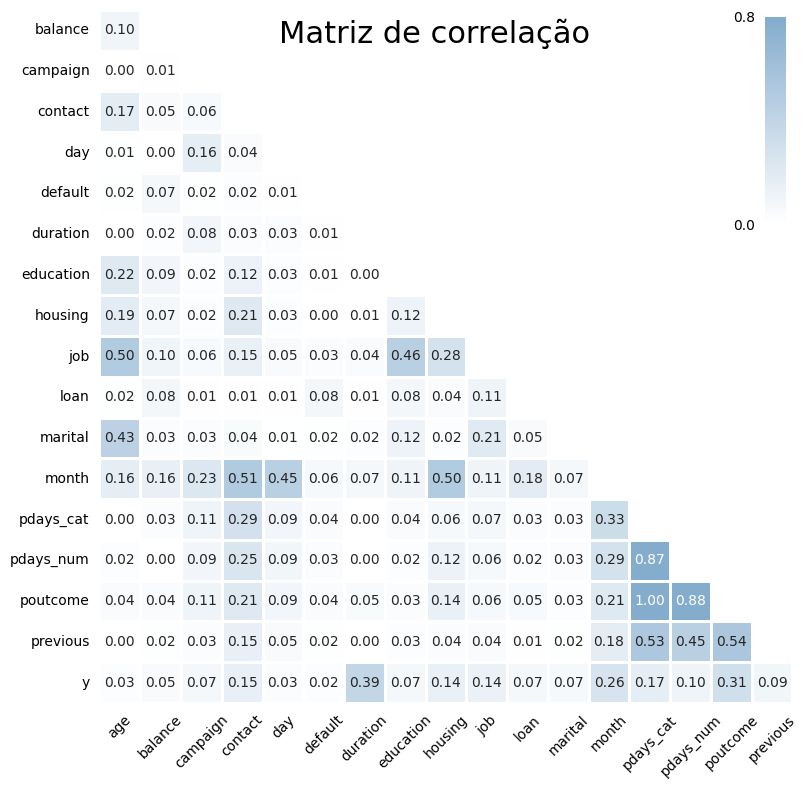

In [169]:
def matriz_correlacao(features):
    # Cálculo das correlações e obtenção do valor absoluto das correlações
    corr = nominal.associations(dataset=bronze_train[features], plot=False, compute_only=True)['corr'].abs()

    # Máscara para o triângulo superior
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Instancia o gráfico
    fig, ax = plt.subplots(figsize=(9, 9))

    # Paleta customizável: Linear gradient from white to steel blue
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_steelblue", ["white", "steelblue"])

    # Remove primeira linha e última coluna, seriam vazias
    corr = corr.iloc[1:, :-1]
    mask = mask[1:, :-1]

    # Desenha o heatmap
    ax = sns.heatmap(data=corr, mask=mask, cmap=cmap, fmt='.2f', cbar=False, vmax=.8,
                     vmin=0, center=0.6, annot=True, square=True, linewidths=2, cbar_kws={"shrink": .5})

    # Rotacionar labels do eixo X em 45 graus
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    ax.tick_params(left=False, bottom=False)

    fig.text(x=.5, y=.87, s="Matriz de correlação", ha="center", va="top", size=22)  # Título
    cbaxes = inset_axes(ax, width="3%", height="30%", loc=1)  # Adicionar eixo de colorbar

    # Cria a colorbar customizada
    clb = plt.colorbar(
        mappable=ax.collections[0],
        cax=cbaxes,
        ticks=[0, .8],
        orientation='vertical',
        drawedges=False,
    )

    # Remove outline, rotate tick labels and remove ticks
    clb.outline.set_visible(False)
    cbaxes.yaxis.tick_left()
    cbaxes.tick_params(left=False, bottom=False)

associations = matriz_correlacao(sorted(bronze_train.columns))

# Eliminando variáveis com correlação maior que 0.8
bronze_train.drop(['pdays_cat', 'pdays_num'], axis=1, inplace=True)

# <a id='3'></a> 3. Relação entre a variável resposta e explicativas

TO_DO

## <a id='3_0'></a> 3.0 Variável resposta *y*

A partir dos resultados, podemos observar que:

- A variável resposta y é binária, indicando se o cliente fez (yes) ou não (no) um depósito a prazo.
- A classe majoritária é no, com 39.922 instâncias (88,3% dos dados).
- A classe minoritária é yes, com 5.289 instâncias (11,7% dos dados).

Denominaremos de **positiva** a classe majoritária e **negativa** a classe minoritária.

Temos um conjunto de dados desbalanceado, com uma grande disparidade entre as classes. Isso será um aspecto importante a ser considerado durante a modelagem dos dados.

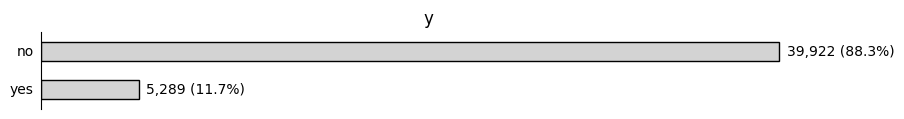

In [170]:
def grafico_barras(coluna, destaque=[]):
    """Cria gráfico de barras para variáveis categóricas com porcentagens."""
    # Contar as ocorrências de cada categoria na coluna especificada
    contagem = bronze_train[coluna].value_counts().sort_values(ascending=True)
    porcentagens = (contagem / contagem.sum() * 100).round(2)  # Calcular porcentagens e arredondar para 2 casas decimais

    altura = len(contagem) * 0.5  # Ajuste de altura baseado no número de categorias

    plt.figure(figsize=(10, altura))
    ax = contagem.plot(kind='barh', 
                       color=['steelblue' if i in destaque else 'lightgray' for i in range(len(contagem))],
                       edgecolor = 'k')
    plt.title(coluna)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks([])
    plt.yticks([])

    # Definir offset para espaçamento dos textos
    max_value = contagem.max()
    offset = max_value * 0.01

    # Adicionar valores e porcentagens à direita de cada barra
    for index, (value, percent) in enumerate(zip(contagem, porcentagens)):
        ax.text(value + offset, index, f'{value:,.0f} ({percent}%)', va='center', ha='left')

    # Adicionar as categorias ao eixo y com espaçamento
    for index, category in enumerate(contagem.index):
        ax.text(-offset, index, category, va='center', ha='right', color='black')

    # Remover os eixos
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.spines['left'].set_visible(True) # Exceto o da esquerda

grafico_barras('y')

## <a id='3_1'></a> 3.1 Variável *age* vs resposta

O histograma da figura à esquerda mostra a idade das pessoas agrupadas em intervalos de aproximadamente 3 anos. Observa-se que o grupo etário de 34-38 anos possui a maior frequência. A frequência diminui progressivamente à medida que a idade aumenta após essa faixa. Podemos observar duas outras modas nas faixas etárias 44-48 e 54-58.

Apesar de pouco representativas, jovens na faixa-etária dos 18-21 apresentam uma resposta superior (31.2%) à média populacional (11.7%).

De forma geral, pessoas das faixas etárias intermediárias e mais representivas (28-58) apresentam baixa proporção de respostas negativas e abaixo da média populacional. A faixa de 48-51, apesar de significativamente expressiva, possui a menor proporção de respostas positivas (8.7%).

O gráfico mostra uma melhora na efetividade das campanhas à partir dos 56 anos, sugerindo um maior engajamento de pessoas em idade avançada. No entanto, essas pessoas não representam uma parcela significativa da população. Por exemplo, o máximo engajamento (80.0%) acontece para o segmento entre 91-95 anos.

Observamos que a faixa etária de 34-38 anos apesar de mais representada, responde mais negativamente do que a média populacional. Pensar em estratégias de campanha para pessoas nessa faixa etária podem trazer maior impacto na variável resposta.

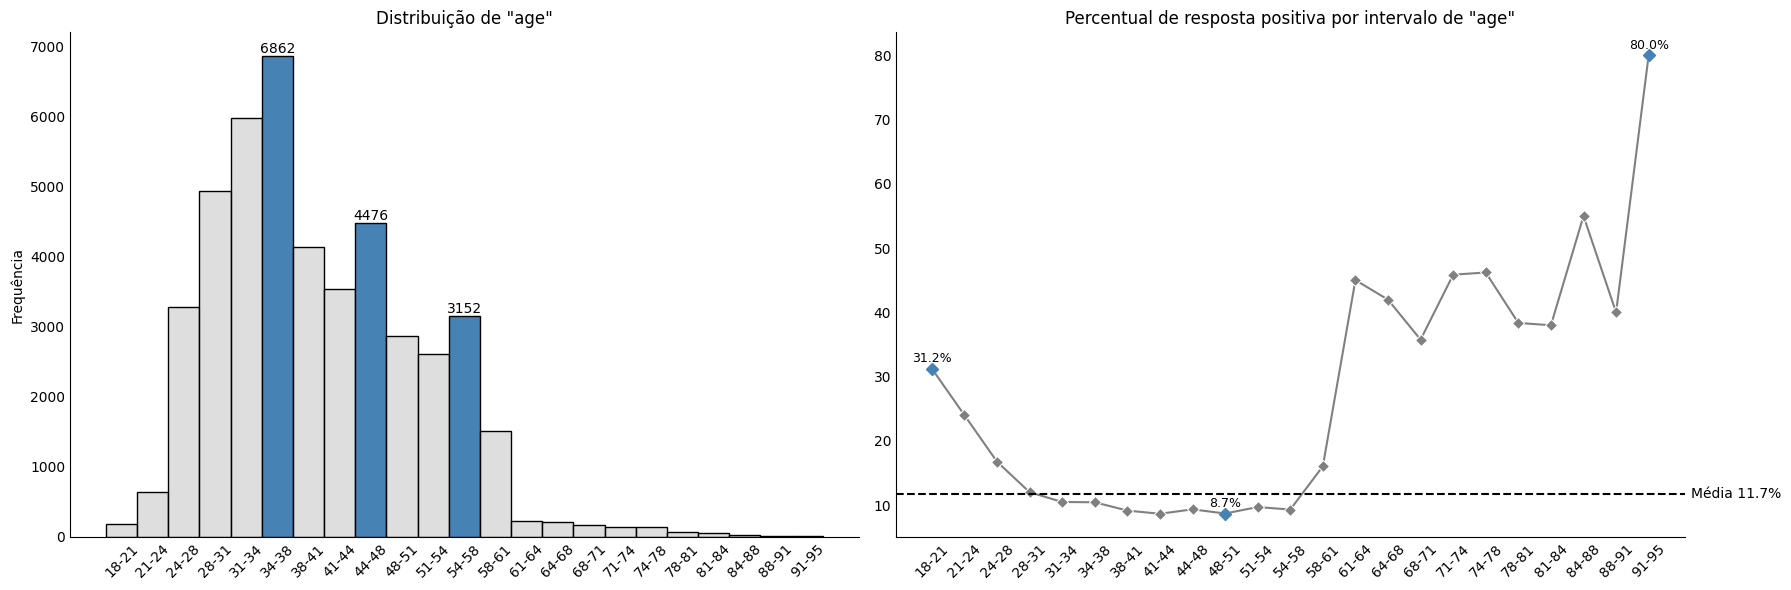

In [171]:
def doane_bins(dados):
    """Calcula o número de bins para o histograma de uma variável com a fórmula de Doane"""
    n = len(dados)  # número de observações
    g1 = skew(dados)  # assimetria dos dados
    # Fórmula de Doane
    sigma_g1 = np.sqrt((6 * (n - 2)) / ((n + 1) * (n + 3)))
    k = 1 + np.log2(n) + np.log2(1 + np.abs(g1) / sigma_g1)
    return int(np.ceil(k))

def histograma_linha(var_numerica, var_resposta='y', destaque_esq=[], destaque_dir=[]):
    df = bronze_train.copy()  # Copia o dataframe para não alterar o original
    num_bins = doane_bins(df[var_numerica])  # Calcula o número de bins com a fórmula de Doane

    # Definir os intervalos com base no número de bins usando np.linspace
    bins = np.linspace(df[var_numerica].min(), df[var_numerica].max(), num_bins+1)

    # Criar a figura
    plt.figure(figsize=(18, 6))
    
    # Histograma
    plt.subplot(1, 2, 1)
    ax = sns.histplot(df[var_numerica], bins=bins, kde=False, color='lightgrey', edgecolor='black')
    # Destacar e anotar barras específicas no histograma
    for bar, patch in enumerate(ax.patches):
        if bar in destaque_esq:
            patch.set_facecolor('steelblue')
            plt.text(patch.get_x() + patch.get_width() / 2, patch.get_height(), int(patch.get_height()), 
                     ha='center', va='bottom', color='black')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)
    plt.title(f'Distribuição de "{var_numerica}"')
    plt.xlabel('')
    plt.xticks(rotation=45)
    plt.ylabel('Frequência')

    # Etiquetas de intervalo para o eixo x do histograma
    bin_labels = [f'{int(bins[i])}-{int(bins[i+1])}' for i in range(len(bins)-1)]
    plt.xticks(ticks=[bins[i]+0.5*(bins[i+1]-bins[i]) for i in range(len(bins)-1)], labels=bin_labels)

    # Agrupar os dados por intervalo da variável numérica
    df[f'{var_numerica}_bin'] = pd.cut(df[var_numerica], bins=bins, right=False, labels=bin_labels)
    grouped = df.groupby(f'{var_numerica}_bin', observed=True)[var_resposta].value_counts(normalize=True).unstack().fillna(0)
    
    # Lineplot para o percentual de resposta positiva
    plt.subplot(1, 2, 2)
    lineplot_data = (grouped['yes'] * 100)
    ax = sns.lineplot(x=lineplot_data.index, y=lineplot_data, marker='D', color='grey')
    # Destaque no lineplot
    for index, percent in enumerate(lineplot_data):  # Correction for TypeError
        if index in destaque_dir:
            plt.plot(lineplot_data.index[index], percent, 'D', color='steelblue')
            plt.text(lineplot_data.index[index], percent + 0.5, f'{percent:.1f}%', ha='center', va='bottom', color='black', fontsize=9)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='both', which='both', length=0)
    plt.xticks(rotation=45)
    plt.title(f'Percentual de resposta positiva por intervalo de "{var_numerica}"')
    plt.xlabel('')
    plt.ylabel('')
    
    # Linha média do percentual de "yes"
    mean_yes = df[var_resposta].value_counts(normalize=True).get('yes', 0) * 100
    plt.axhline(y=mean_yes, color='black', linestyle='--')
    plt.text(plt.xlim()[1] + 0.2, mean_yes, f'Média {mean_yes:.1f}%', ha='left', va='center', color='black')
    
    plt.tight_layout()
    plt.show()

histograma_linha('age', destaque_esq=[5, 8, 11], destaque_dir=[0, 9, 22])

## <a id='3_3'></a> 3.3 Variável *balance* vs resposta

A distribuição da variável *balance* contém uma distribuição muito centrada em torno da mediana e possui muitos outliers. Com a finalidade de estudar o comportamento majoritário da distribuição, removemos os outliers da visualização de ambos o histograma e dos boxplot.

A distribuição de *balance* sem outliers possui assimetria positiva. A moda (9318) indica que a maioria dos clientes possui saldo próximo de 0.
O boxplot compara a distribuição de balance dividida entre resposta positiva e resposta negativa. Pessoas da classe positiva tendem a ter saldos mais altos (536) comparados àqueles da classe negativa (328).

Um insight acionável seria focar em estratégias de campanha voltadas para pessoas com saldo maior.

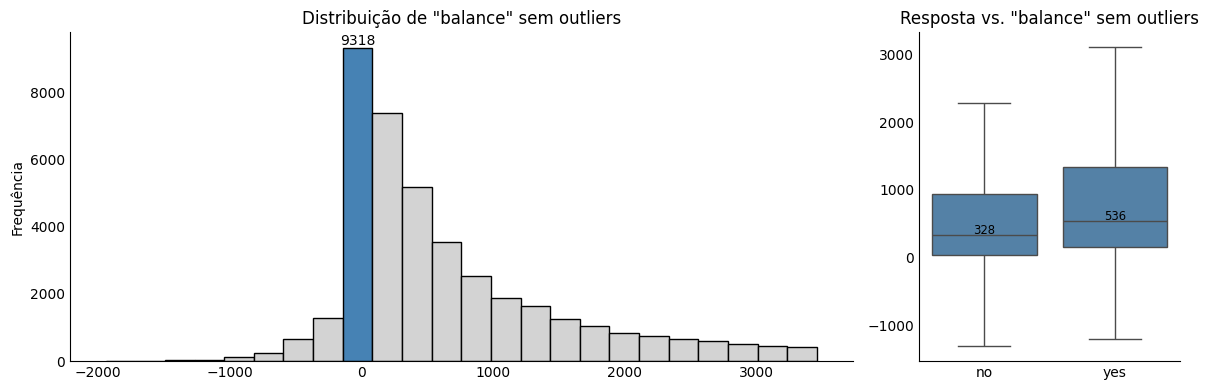

In [172]:
def histograma_boxplot(coluna, destaque_esq=[], destaque_dir=[], outliers=False):
    df = bronze_train.copy()  # Copia o dataframe para não alterar o original

    if not outliers:
        # Calculando os limites de outliers com base na técnica do IQR
        Q1 = df[coluna].quantile(0.25)
        Q3 = df[coluna].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filtrando os dados sem outliers
        df = df[(df[coluna] >= lower_bound) & (df[coluna] <= upper_bound)]
    
    # Configurando o layout com proporção 3:1 para os dois subplots
    _, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 1]})
    
    # Histograma sem outliers
    ax1.hist(df[coluna], bins=doane_bins(df[coluna]), color='lightgrey', edgecolor='k')
    # Destacar e anotar barras específicas no histograma
    for bar, patch in enumerate(ax1.patches):
        if bar in destaque_esq:
            patch.set_facecolor('steelblue')
            ax1.text(patch.get_x() + patch.get_width() / 2, patch.get_height(), int(patch.get_height()), 
                     ha='center', va='bottom', color='black')
    ax1.set_title(f'Distribuição de "{coluna}" sem outliers')
    ax1.set_xlabel('')
    ax1.set_ylabel('Frequência')
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.tick_params(axis='both', which='both', length=0)
    
    # Boxplot sem outliers
    sns.boxplot(x='y', y=coluna, data=df, showfliers=outliers, ax=ax2, color='lightgrey', hue='y', 
        palette={x: 'steelblue' if x in destaque_dir else 'lightgrey' for x in df['y'].unique()}, 
        legend=False)
    ax2.set_title(f'Resposta vs. "{coluna}" sem outliers')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.tick_params(axis='both', which='both', length=0)

    # Adicionando a mediana acima de cada boxplot
    medians = df.groupby(['y'])[coluna].median()
    vertical_offset = df[coluna].median() * 0.05  # pequeno ajuste para não sobrepor o texto no boxplot
    
    for xtick, label in enumerate(ax2.get_xticklabels()):
        label_text = label.get_text()
        if label_text in destaque_dir:
            ax2.text(xtick, medians[label_text] + vertical_offset, f'{medians[label_text]:.0f}', 
                     horizontalalignment='center', size='small', color='black')
    
    plt.tight_layout()
    plt.show()

histograma_boxplot('balance', destaque_esq=[8], destaque_dir=['no', 'yes'], outliers=False)

## <a id='3_4'></a> 3.4 Variável *pdays* vs resposta

TO_DO